In [1]:
%matplotlib inline
import os
from pathlib import Path
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore")

import matplotlib
from math import sqrt


SPINE_COLOR = 'black'


def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.487 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 12.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES
    # , '\usepackage{amsmath, amsfonts}',
    params = {'backend': 'pdf',
              'text.latex.preamble': [r'\usepackage{amsmath}',
                                      r'\usepackage{amssymb}',
                                      r'\usepackage{gensymb}',
                                      # r'\usepackage{mathabx}',
                                      r'\usepackage{amsfonts}',
                                      r'\usepackage{newtxmath}'],
              'axes.labelsize': 14,  # fontsize for x and y labels (was 10)
              'axes.titlesize': 20,
              'font.size': 8,   # was 10
              'legend.fontsize': 8,     # was 10
              'legend.shadow': False,
              'legend.fancybox': True,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12,
              'text.usetex': True,
              'figure.figsize': [fig_width, fig_height],
              'font.family': 'serif',
              'font.serif': 'times new roman',
              'patch.linewidth': 0.5
              }

    matplotlib.rcParams.update(params)


def format_axes(ax, title=None, xlabel=None, ylabel=None, leg_loc=None, grid=None):

    for spine in ['top', 'right']:
        # ax.spines[spine].set_visible(False)
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.7)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.7)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel, labelpad=0.4)
    if ylabel is not None:
        ax.set_ylabel(ylabel, labelpad=0.3)
    if leg_loc is not None:
        ax.legend(loc=leg_loc)
    if grid is not None:
        ax.grid(grid, lw=0.3)
    return ax

# rc("text", usetex=True)
# rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
# rc("grid", linestyle="-", color="gray")
# font = {"family": "sans-serif", "weight": "bold", "size": 10}
# rc("font", **font)
# rc("xtick", labelsize=12)
# rc("ytick", labelsize=12)

linestyles = ['-', '--', '-.', ':']
# cmap = plt.cm.coolwarm
cmap = plt.cm.RdYlBu

In [2]:
def csvtodf(fname):
    """Read and process csv file to pandas dataframe"""
    return pd.read_csv(fname, sep=";", index_col=0)

def plot_csv(ax, csvfile, step=1, tfn=lambda x: x, alpha=0.3, **kwargs):
    df = csvtodf(csvfile)
    mean = tfn(df["mean"])
    line, *_ = ax.plot(df.index.values[::step], mean.values[::step], **kwargs)
    ax.fill_between(
        df.index.values[::step],
        (mean - df["std"]).values[::step],
        (mean + df["std"]).values[::step],
        alpha=alpha,
        color=line.get_c()
    )
    return line

# plot from csv files
def plot_csvs(
    ax,
    csvdict,
    step=1,
    tfn=lambda x: x,
    alpha=0.3,
    xlabel="Epoch",
    ylabel="ylabel",
    title="Default Title",
    legend_loc="lower right",
    lslabels=",".split(","),
    **kwargs
):
    """Given a dict of names -> csv paths, plot it"""
    lines = []
    append = False
    N = len(csvdict) - 1
    for i, (name, csv_files) in enumerate(csvdict.items()):
        for j, csvpath in enumerate(csv_files):
            color = cmap(i / N)
            ls = linestyles[j % 4]
            df = csvtodf(csvpath)
            mean = tfn(df["mean"])
#             line, *_ = ax.plot(df.index.values, df["mean"].values, color=color, 
#                            label=name.replace("_", "\_"), 
#                            linestyle=ls, **kwargs)
            if j == 0:
                line, *_ = ax.plot(df.index.values[::step], mean.values[::step], label=name.replace("_", "\_"), linestyle=ls, **kwargs)
            else:
                line, *_ = ax.plot(df.index.values[::step], mean.values[::step], linestyle=ls, **kwargs)
            ax.fill_between(
                df.index.values[::step],
                (mean - df["std"]).values[::step],
                (mean + df["std"]).values[::step],
                alpha=alpha, color=line.get_c()
            )
            lines.append(line)
        append = j > 0
    if append:
        for lsi, label in enumerate(lslabels):
            lines.append(Line2D([0], [0], label=label, linestyle=linestyles[lsi % 4], lw=4, color="black"))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
#     ax.set_title(r"\textbf{" + title + "}", fontsize=20)
    if title is not None:
        ax.set_title(title)
    # legend = ax.legend(loc=legend_loc, fontsize="x-large")
    ax.grid(alpha=0.2)
    return lines

In [3]:
RUNDIR = Path("runs")

def plot_mnist(ax, experiments, pattern="validaccuracy", **kwargs):
    csvdict = {}
    for name, subdir in experiments.items():
        csvdict[name] = sorted([*RUNDIR.joinpath(subdir, "aggregates").glob(f"{pattern}*.csv")])
    return plot_csvs(ax, csvdict, **kwargs)

In [4]:
METHODS = [
    #"epo",
    "GradDrop",
    #"graddrop_random",
    #"graddrop_deterministic",
    "GradNorm",
    "GradVacc",
    #"gradortho",
    #"gradalign",
    "Individual",
    "ITMTL",
    "MGDA",
    "PCGrad",
    "Linscalar",
    # "pmtl",
]
DATASETS = ["MNIST", "Fashion", "Fashion and MNIST"]
NETWORKS = ["lenet", "resnet18"]
SUFFIXES = dict((method, "p0") for method in METHODS if method != "Individual")

FIGDIR = Path("figures")
if not FIGDIR.exists():
    FIGDIR.mkdir(exist_ok=False)
    
figpath = lambda b: FIGDIR.joinpath(b)
SAVEFIGS = True

EXPS = {}
for dset_name in DATASETS:
    for arch in NETWORKS:
        exps = {}
        for method_name in METHODS:
            method = method_name.lower()
            dset = dset_name.lower().replace(" ", "_")
            if method != "individual":
                exps[method_name] = f"{method}_{dset}_{arch}_100-" + SUFFIXES[method_name]
        EXPS[f"{dset_name}_{arch}"] = exps

# store csv's directly here
SOLO = {}
for dset_name in DATASETS:
    for arch in NETWORKS:
        for t in range(2):
            subdir = f"individual_{dset}_{arch}_100-t{t}"
            csvlist = [*RUNDIR.joinpath(subdir, "aggregates").glob("*.csv")]
            SOLO[f"{dset_name}_{arch}_{t}"] = sorted(csvlist)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


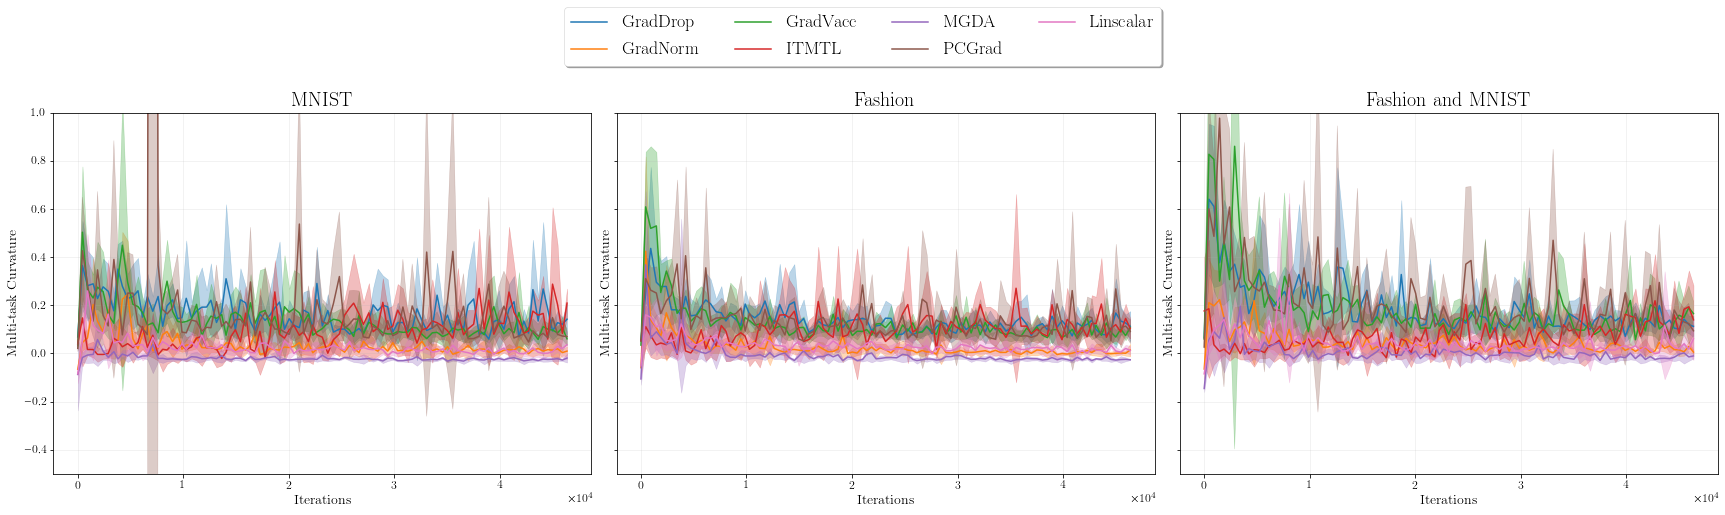

In [5]:
latexify(24, 6)
f, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
arch = "lenet"
for i, dset in enumerate(DATASETS[:]):
    plot_mnist(axes[i], EXPS[f"{dset}_{arch}"], pattern="multi-task_curvature", step=100, xlabel="Iterations", ylabel="Multi-task Curvature", title=dset)
    axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axes[i].set_ylim([-0.5, 1])
f.tight_layout()
handles, labels = axes[-1].get_legend_handles_labels()
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, fancybox=True, shadow=True, fontsize=18)
if SAVEFIGS:
    f.savefig(figpath(f"mnist_{arch}_mtc.pdf"), bbox_inches="tight")
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


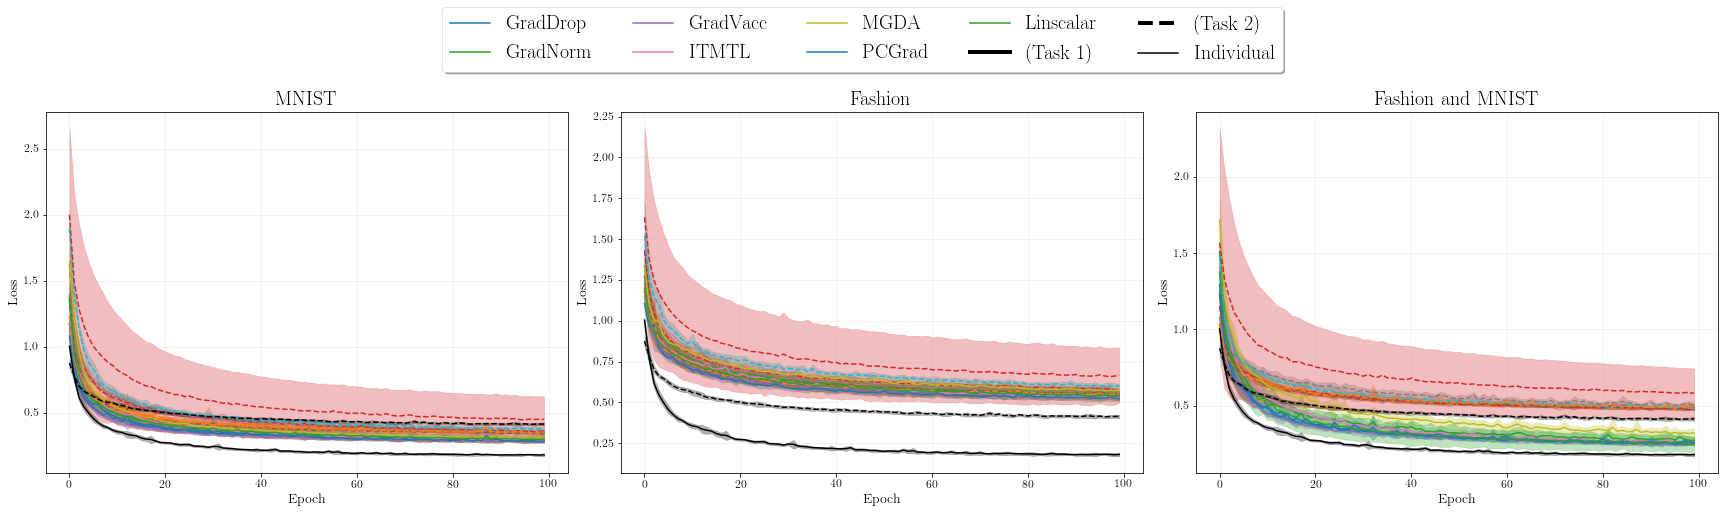

In [6]:
latexify(24, 6)
f, ax_loss = plt.subplots(nrows=1, ncols=3, sharex=True)
arch = "lenet"
for i, dset in enumerate(DATASETS[:]):
    llines = plot_mnist(ax_loss[i], EXPS[f"{dset}_{arch}"], pattern="validloss", ylabel="Loss", title=dset, lslabels=" (Task 1), (Task 2)".split(","))
    llines.append(plot_csv(ax_loss[i], SOLO[f"{dset}_{arch}_0"][-2], label="Individual", linestyle=linestyles[0], color="black"))
    llines.append(plot_csv(ax_loss[i], SOLO[f"{dset}_{arch}_1"][-1], linestyle=linestyles[1], color="black"))
# for i, dset in enumerate(DATASETS[:]):
#     alines = plot_mnist(ax_acc[i], EXPS[f"{dset}_{arch}"], pattern="validacc", ylabel="accuracy", title=None, lslabels=" (Task 1), (Task 2)".split(","))
#     alines.append(plot_csv(ax_acc[i], SOLO[f"{dset}_{arch}_0"][3], label="individual", linestyle=linestyles[0], color="black"))
#     alines.append(plot_csv(ax_acc[i], SOLO[f"{dset}_{arch}_1"][-3], linestyle=linestyles[1], color="black"))
f.tight_layout()
f.legend(handles=llines, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5, fancybox=True, shadow=True, fontsize=20)
if SAVEFIGS:
    f.savefig(figpath(f"mnist_{arch}_loss.pdf"), bbox_inches="tight")
plt.show()

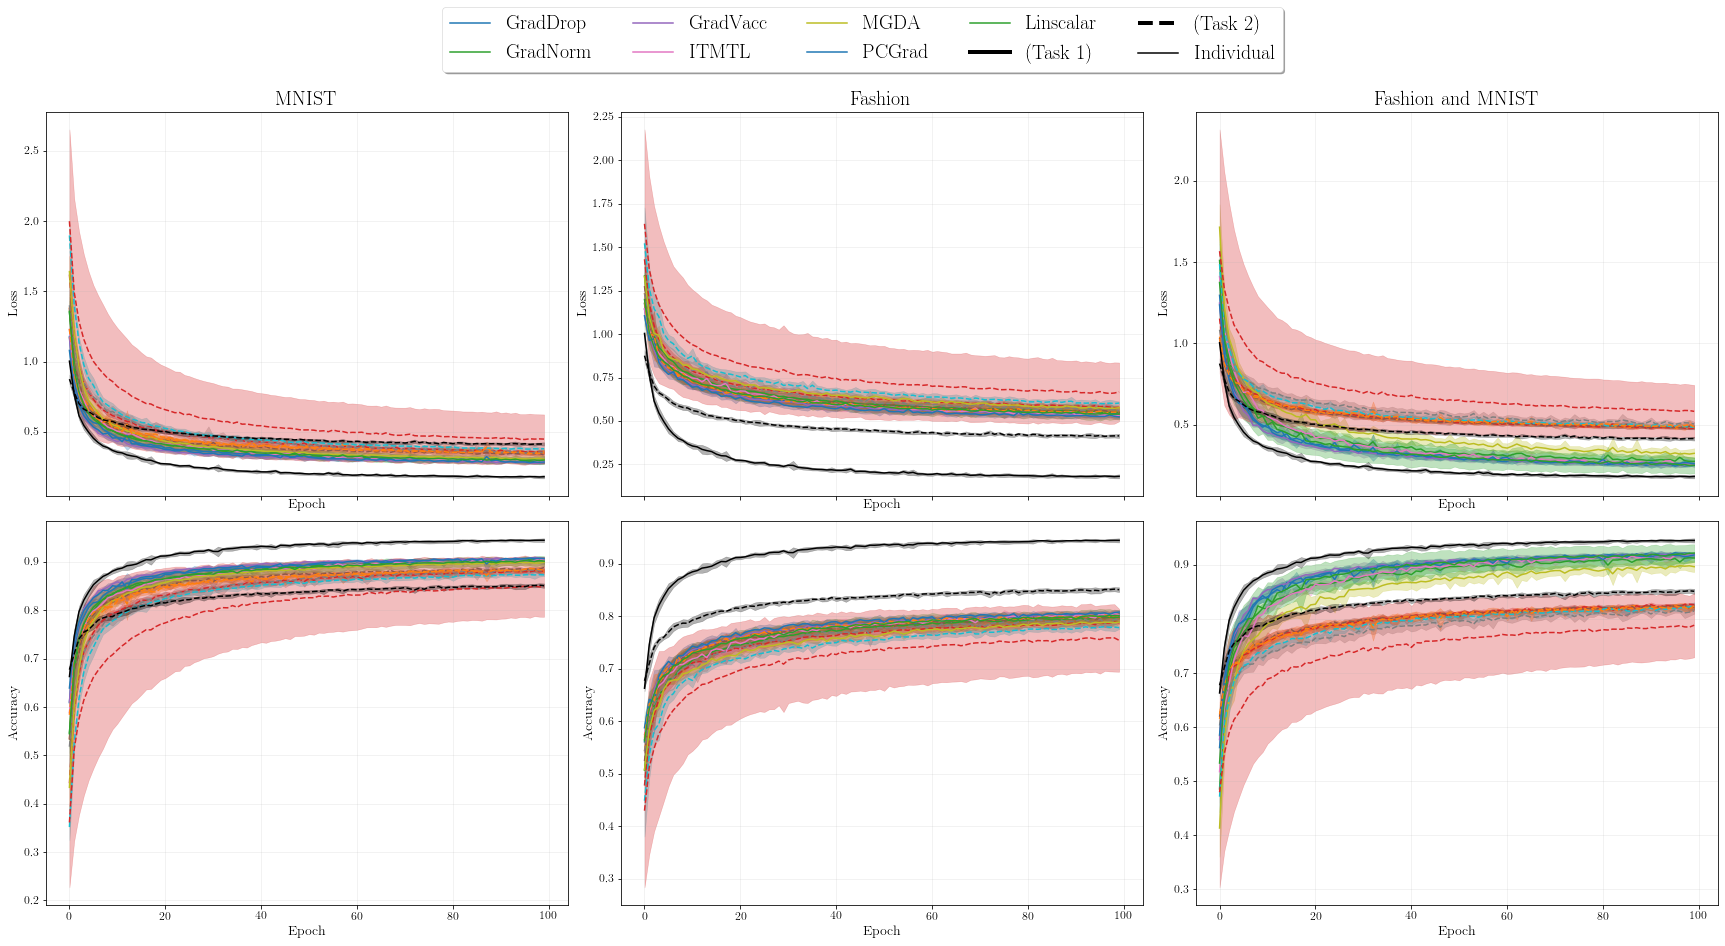

In [7]:
latexify(24, 12)
f, (ax_loss, ax_acc) = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(24, 12))
arch = "lenet"
for i, dset in enumerate(DATASETS[:]):
    llines = plot_mnist(ax_loss[i], EXPS[f"{dset}_{arch}"], pattern="validloss", ylabel="Loss", title=dset, lslabels=" (Task 1), (Task 2)".split(","))
    llines.append(plot_csv(ax_loss[i], SOLO[f"{dset}_{arch}_0"][-2], label="Individual", linestyle=linestyles[0], color="black"))
    llines.append(plot_csv(ax_loss[i], SOLO[f"{dset}_{arch}_1"][-1], linestyle=linestyles[1], color="black"))
for i, dset in enumerate(DATASETS[:]):
    alines = plot_mnist(ax_acc[i], EXPS[f"{dset}_{arch}"], pattern="validacc", ylabel="Accuracy", title=None, lslabels=" (Task 1), (Task 2)".split(","))
    alines.append(plot_csv(ax_acc[i], SOLO[f"{dset}_{arch}_0"][3], label="Individual", linestyle=linestyles[0], color="black"))
    alines.append(plot_csv(ax_acc[i], SOLO[f"{dset}_{arch}_1"][-3], linestyle=linestyles[1], color="black"))
f.tight_layout()
# handles, labels = ax_loss[-1].get_legend_handles_labels()
# f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, fancybox=True, shadow=True, fontsize="x-large")
f.legend(handles=llines, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fancybox=True, shadow=True, fontsize=20)
if SAVEFIGS:
    f.savefig(figpath(f"mnist_{arch}_loss_acc.pdf"), bbox_inches="tight")
plt.show()

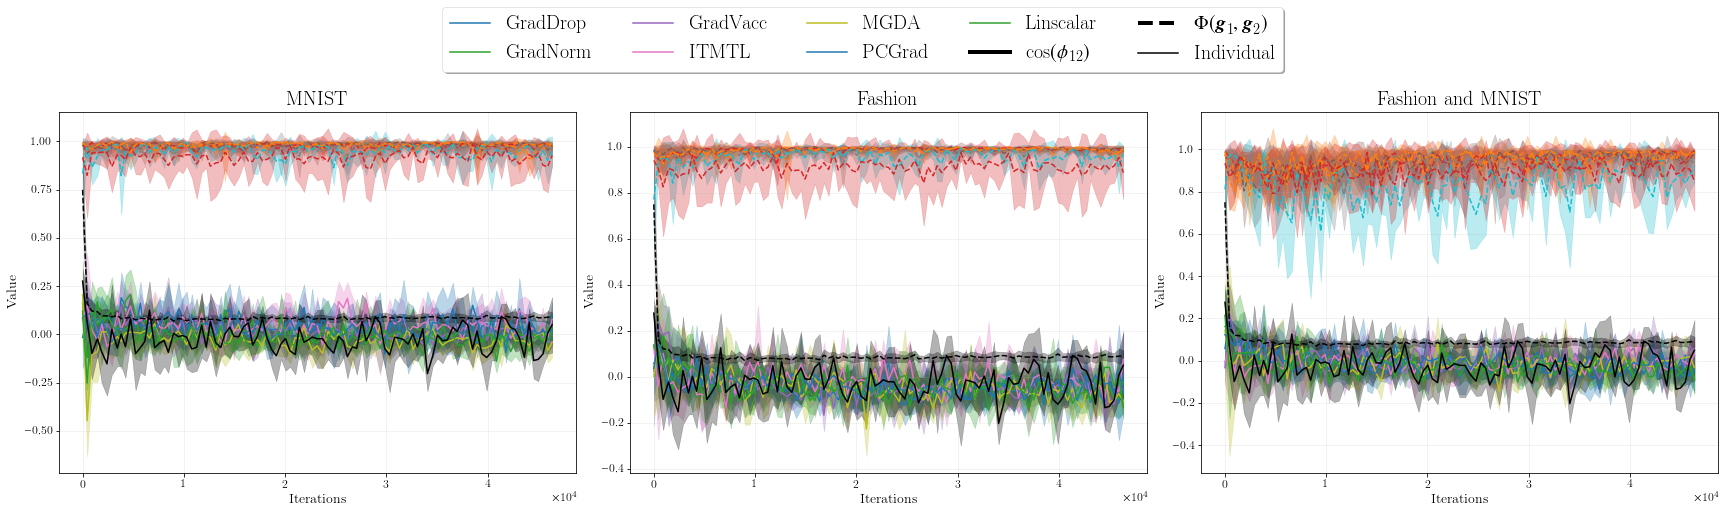

In [8]:
latexify(24, 6)
f, axes = plt.subplots(ncols=3, sharex=True, figsize=(24, 6))
arch = "lenet"
lslabels = [r" $\cos(\phi_{12})$" , r"$\Phi(\boldsymbol{g}_1, \boldsymbol{g}_2)$"]
for i, dset in enumerate(DATASETS[:]):
    lines = plot_mnist(axes[i], EXPS[f"{dset}_{arch}"], pattern="tasks_0_1", step=100, xlabel="Iterations", ylabel="Value", title=dset, lslabels=lslabels)
    lines.append(plot_csv(axes[i], SOLO[f"{dset}_{arch}_0"][1], step=100, label="Individual", linestyle=linestyles[0], color="black"))
    lines.append(plot_csv(axes[i], SOLO[f"{dset}_{arch}_1"][2], step=100, linestyle=linestyles[1], color="black"))
    axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
f.tight_layout()
f.legend(handles=lines, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5, fancybox=True, shadow=True, fontsize=20)
if SAVEFIGS:
    f.savefig(figpath(f"mnist_{arch}_ang_gms_single.pdf"), bbox_inches="tight")
plt.show()

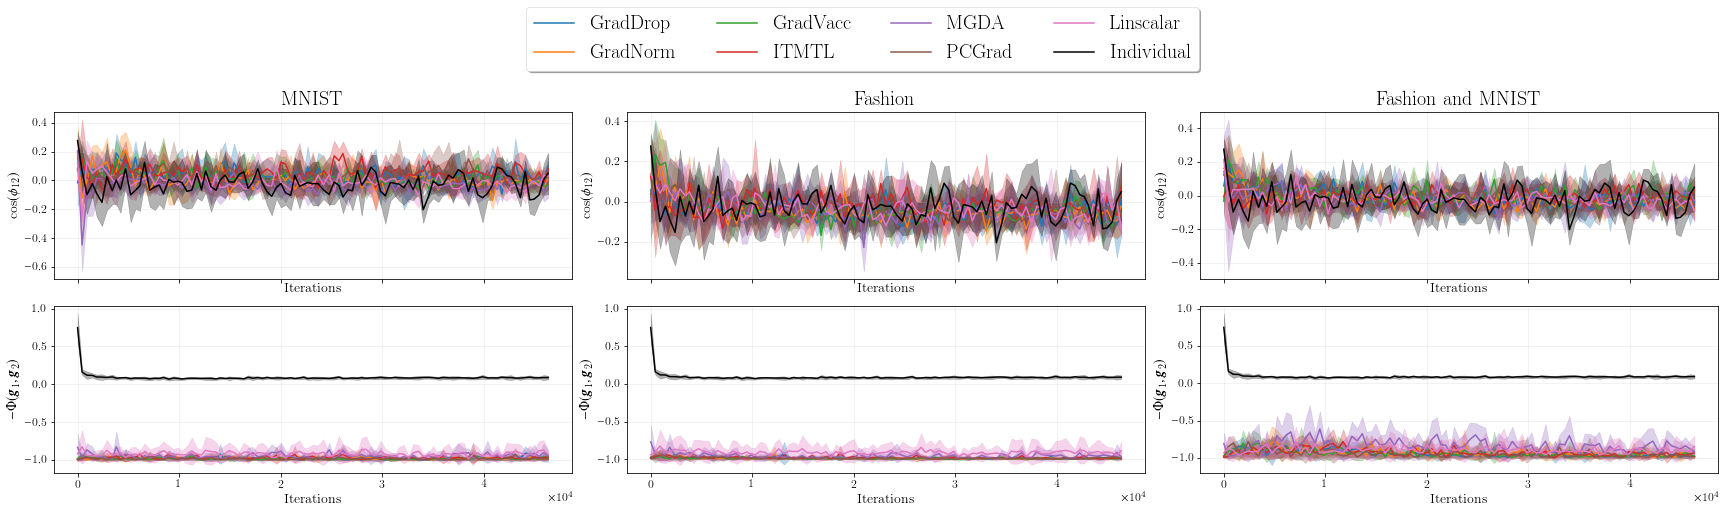

In [9]:
latexify(24, 6)
f, (ax_cos, ax_gms) = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(24, 6))
arch = "lenet"
lslabels = [r" $\cos(\phi_{12})$" , r"$\Phi(\boldsymbol{g}_1, \boldsymbol{g}_2)$"]
for i, dset in enumerate(DATASETS[:]):
    lines = plot_mnist(ax_cos[i], EXPS[f"{dset}_{arch}"], pattern="*cosine_angle", step=100, xlabel="Iterations", ylabel=r"$\cos(\phi_{12})$", title=dset, lslabels=lslabels)
    lines.append(plot_csv(ax_cos[i], SOLO[f"{dset}_{arch}_0"][1], step=100, label="Individual", linestyle=linestyles[0], color="black"))
    ax_cos[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
for i, dset in enumerate(DATASETS[:]):
    lines = plot_mnist(ax_gms[i], EXPS[f"{dset}_{arch}"], pattern="*grad_magnitude", step=100, tfn=lambda x: -x, xlabel="Iterations", ylabel=r"$-\Phi(\boldsymbol{g}_1, \boldsymbol{g}_2)$", title=None, lslabels=lslabels)
    lines.append(plot_csv(ax_gms[i], SOLO[f"{dset}_{arch}_1"][2], step=100, label="Individual", linestyle=linestyles[0], color="black"))
    ax_gms[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
f.tight_layout()
f.legend(handles=lines, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, fancybox=True, shadow=True, fontsize=20)
if SAVEFIGS:
    f.savefig(figpath(f"mnist_{arch}_ang_gms_double.pdf"), bbox_inches="tight")
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


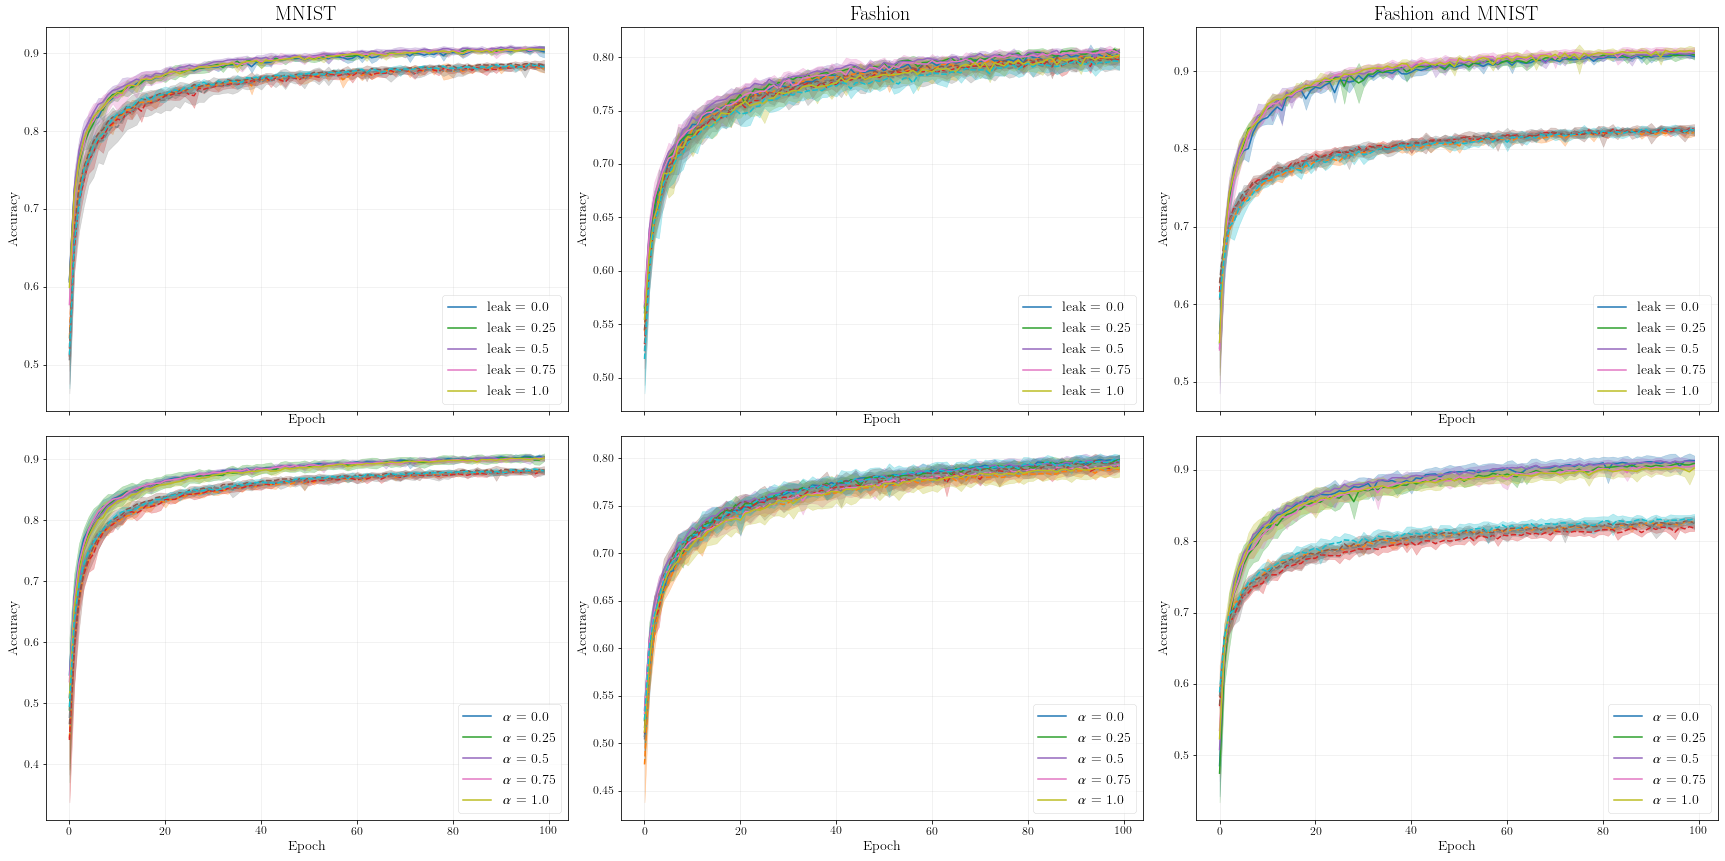

In [10]:
# hyperparameter sweep for graddrop and gradnorm
HYPATTN = "validacc"
HYPEXPS = {}
gd_exps = {}
arch = "lenet"
for dset_name in DATASETS:
    dset = dset_name.lower().replace(" ", "_")
    gd_exps = {}
    for i, leak in enumerate(np.arange(0, 1.1, 1./4)):
        subdir = f"graddrop_{dset}_{arch}_100-p{i}"
        gd_exps[f"leak = {leak}"] = sorted(*[RUNDIR.joinpath(subdir, "aggregates").glob(f"{HYPATTN}*.csv")])
    HYPEXPS[f"graddrop_{dset_name}"] = gd_exps
    gn_exps = {}
    for i, alpha in enumerate(np.arange(0, 1.1, 1./4)):
        subdir = f"gradnorm_{dset}_{arch}_100-p{i}"
        gn_exps[r"$\alpha$" + f" = {alpha}"] = sorted(*[RUNDIR.joinpath(subdir, "aggregates").glob(f"{HYPATTN}*.csv")])
    HYPEXPS[f"gradnorm_{dset_name}"] = gn_exps

latexify(24, 12)
lslabels = " (Task 1), (Task 2)".split(",")
f, axes = plt.subplots(ncols=3, nrows=2, sharex=True)
for i, method in enumerate(["graddrop", "gradnorm"]): 
    for j, dset in enumerate(DATASETS):
        lines = plot_csvs(axes[i][j], HYPEXPS[f"{method}_{dset}"], ylabel="Accuracy", title=dset if i == 0 else None, lslabels=lslabels)
#         if j == 1:
        axes[i][j].legend(loc="lower right", fontsize=14)
f.tight_layout()
# handles, labels = axes[0][1].get_legend_handles_labels()
# f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, fancybox=True, shadow=True, fontsize="x-large")
# f.legend(handles=lines, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, fancybox=True, shadow=True, fontsize=20)
if SAVEFIGS:
    f.savefig(figpath(f"mnist_{arch}_hyperparameter.pdf"), bbox_inches="tight")
plt.show()

In [11]:
TABDIR = Path("tables")
if not TABDIR.exists():
    TABDIR.mkdir(exist_ok=False)

In [12]:
# table of final validation accuracies
NTASKS = 2
CSVS = {}
arch = "lenet"
for dset_name in DATASETS[:]:
    dset = dset_name.lower().replace(" ", "_")
    
    for method_name in METHODS[:]:
        method = method_name.lower()
        if method != "individual":
            subdir = f"{method}_{dset}_{arch}_100-p0"
            CSVS[f"{method_name}_{dset_name}"] = sorted(*[RUNDIR.joinpath(subdir, "aggregates").glob("validacc*.csv")])
    # individual
    csvs = []
    for t in range(NTASKS):
        subdir = f"individual_{dset}_{arch}_100-t{t}"
        fname = sorted(*[RUNDIR.joinpath(subdir, "aggregates").glob("validacc*.csv")])[t]
        csvs.append(fname)
    CSVS[f"Individual_{dset_name}"] = csvs

from collections import defaultdict
DATA = defaultdict(list)
for method in METHODS[:]:
    DATA[("method",)].append(method)
    for dset in DATASETS[:]:
        for t in range(NTASKS):
            df = csvtodf(CSVS[f"{method}_{dset}"][t])
            entry = (dset, f"Task {t}")
            avg, std = df["mean"].values[-1], df["std"].values[-1]
            val = f"{avg:.3f}" + r" $\pm$ " + f"{std:.3f}"
            DATA[entry].append(val)

DF = pd.DataFrame(DATA)
with open(TABDIR.joinpath(f"table_mnist_{arch}.tex"), "w") as f:
    f.write(DF.to_latex(index=False, 
                        caption="Final validation set accuracies on the "
                        "Multi-MNIST + Fashion dataset across the two tasks. "
                        "Each value is averaged over 5 random seeds", 
                        label="table:mnist-lenet", escape=False,
                        column_format="c" * len(DF.columns), multicolumn_format="c"
                       )
           )
DF

method              MNIST                               Fashion  \
          NaN             Task 0             Task 1             Task 0   
0    GradDrop  0.902 $\pm$ 0.007  0.880 $\pm$ 0.005  0.804 $\pm$ 0.004   
1    GradNorm  0.902 $\pm$ 0.004  0.882 $\pm$ 0.003  0.799 $\pm$ 0.004   
2    GradVacc  0.907 $\pm$ 0.003  0.889 $\pm$ 0.004  0.802 $\pm$ 0.003   
3  Individual  0.912 $\pm$ 0.002  0.888 $\pm$ 0.005  0.816 $\pm$ 0.002   
4       ITMTL  0.904 $\pm$ 0.003  0.882 $\pm$ 0.004  0.803 $\pm$ 0.008   
5        MGDA  0.900 $\pm$ 0.006  0.873 $\pm$ 0.003  0.789 $\pm$ 0.005   
6      PCGrad  0.907 $\pm$ 0.003  0.884 $\pm$ 0.004  0.808 $\pm$ 0.004   
7   Linscalar  0.902 $\pm$ 0.010  0.849 $\pm$ 0.062  0.802 $\pm$ 0.011   

                      Fashion and MNIST                     
              Task 1             Task 0             Task 1  
0  0.801 $\pm$ 0.005  0.919 $\pm$ 0.003  0.821 $\pm$ 0.004  
1  0.788 $\pm$ 0.002  0.913 $\pm$ 0.007  0.827 $\pm$ 0.002  
2  0.801 $\pm$ 0.005  0.919 $\pm$ 0.005  0.822 $\pm$ 0.006  
3  0.813 $\pm$ 0.006  0.945 $\pm$ 0.004  0.851 $\pm$ 0.005  
4  0.795 $\pm$ 0.009  0.918 $\pm$ 0.004  0.815 $\pm$ 0.005  
5  0.779 $\pm$ 0.003  0.897 $\pm$ 0.010  0.824 $\pm$ 0.006  
6  0.802 $\pm$ 0.005  0.918 $\pm$ 0.003  0.824 $\pm$ 0.003  
7  0.755 $\pm$ 0.060  0.922 $\pm$ 0.016  0.788 $\pm$ 0.059

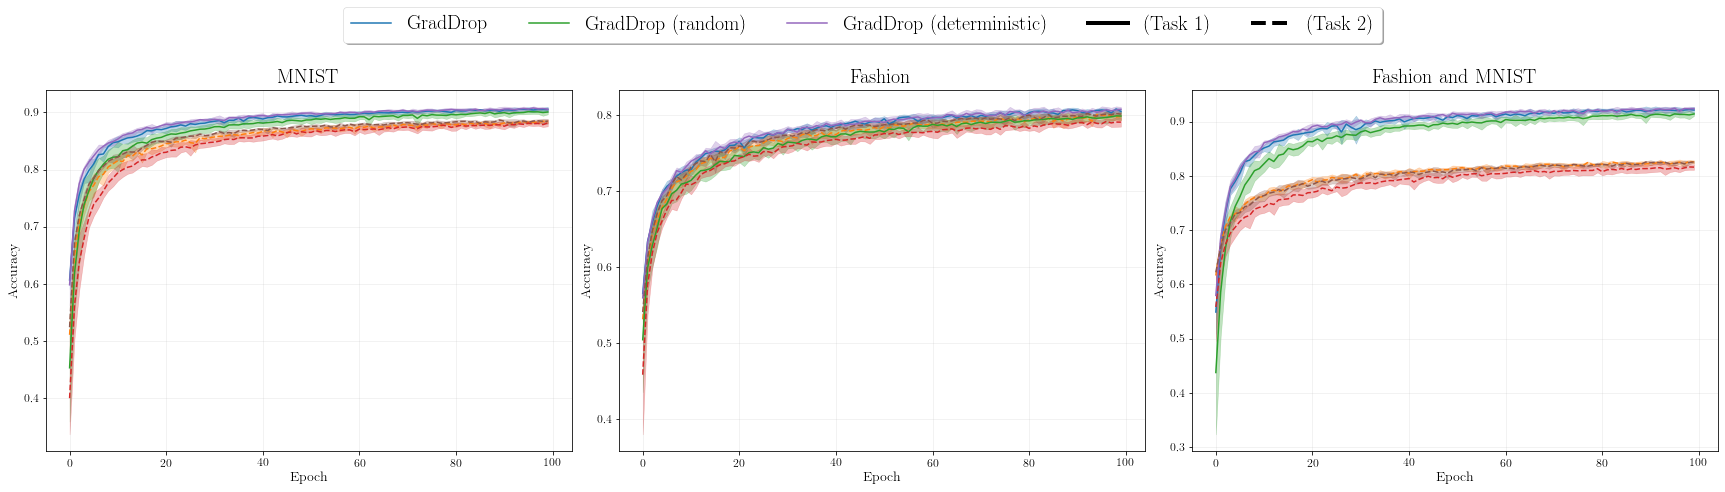

In [13]:
# graddrop ablation
HYPATTN = "validacc"
NTASKS = 2
HYPEXPS = {}
GDMETHODS = ["GradDrop", "GradDrop (random)", "GradDrop (deterministic)"]
arch = "lenet"
for dset_name in DATASETS:
    dset = dset_name.lower().replace(" ", "_")
    gd_exps = {}
    for method_name in GDMETHODS:
        method = method_name.lower().replace('(', '').replace(')', '').replace(' ', '_')
        subdir = f"{method}_{dset}_{arch}_100-p{i}"
        gd_exps[method_name] = sorted(*[RUNDIR.joinpath(subdir, "aggregates").glob(f"{HYPATTN}*.csv")])
    HYPEXPS[dset_name] = gd_exps

latexify(24, 6)
lslabels = " (Task 1), (Task 2)".split(",")
f, axes = plt.subplots(ncols=3, nrows=1, sharex=True)
for i, dset in enumerate(DATASETS):
    lines = plot_csvs(axes[i], HYPEXPS[dset], ylabel="Accuracy", title=dset, lslabels=lslabels)
f.tight_layout()
f.legend(handles=lines, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=True, shadow=True, fontsize=20)
if SAVEFIGS:
    f.savefig(figpath(f"mnist_{arch}_graddrop.pdf"), bbox_inches="tight")
plt.show()